In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLS import  estimateNorm
from LSSVM import predict, accuracy, linearKernel
import LSSVM
from VQLSSVM import VQLSSVM

In [2]:
shots: int = 10000
gamma: float = 0.01 # regularization parameter
testSize: float = 0.2
subsetSize: int = 7

In [3]:
vqlssvm: VQLSSVM = VQLSSVM(gamma, shots)

In [4]:
X, y = datasets.make_classification(
    n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
)
y: np.array = np.where(y == 0, -1, 1)
xTrain, xTest, yTrain, yTest = train_test_split(
    X, y, test_size=testSize, random_state=42
)
subsetIndices  = np.random.choice(np.arange(xTrain.shape[0]), subsetSize, replace=False)
xSubset = np.array([xTrain[i] for i in subsetIndices])
ySubset = np.array([yTrain[i] for i in subsetIndices])

LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.02902670e+02  1.63683201e-01 -2.15784712e-04
  -2.22014439e+00 -3.21493458e-01  8.06687868e-01  4.50215586e-01]
 [ 1.00000000e+00  1.63683201e-01  1.01875017e+02  6.55066943e-01
   5.38214142e-02 -1.61763539e+00 -1.86508618e+00  1.73882042e+00]
 [ 1.00000000e+00 -2.15784712e-04  6.55066943e-01  1.00229999e+02
   6.30178954e-02 -5.61563812e-01 -6.70864417e-01  6.01553851e-01]
 [ 1.00000000e+00 -2.22014439e+00  5.38214142e-02  6.30178954e-02
   1.01715282e+02  9.24306157e-02 -8.00319446e-01 -1.79954494e-01]
 [ 1.00000000e+00 -3.21493458e-01 -1.61763539e+00 -5.61563812e-01
   9.24306157e-02  1.01406836e+02  1.54855574e+00 -1.51876023e+00]
 [ 1.00000000e+00  8.06687868e-01 -1.86508618e+00 -6.70864417e-01
  -8.00319446e-01  1.54855574e+00  1.02180628e+02 -1.62944342e+00]
 [ 1.00000000e+00  4.50215586e-01  1.73882042e+00  6.0

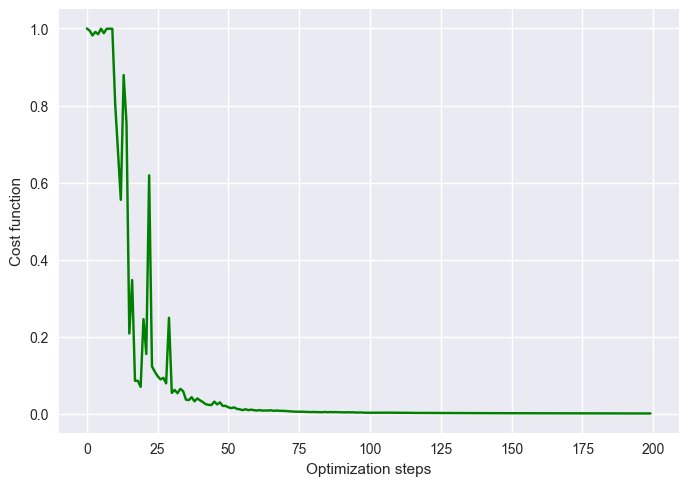

In [5]:
vqlssvm.train(xSubset, ySubset, quantumSimulation=False, verbose=True, iterations = 200)

vqlssvm.plotCost()

In [6]:
print(vqlssvm.predict(xTest))

[ 0.03089334+0.j  0.01770941+0.j -0.01204764+0.j -0.03865697+0.j
 -0.02890778+0.j -0.02337878+0.j  0.0326194 +0.j -0.04270569+0.j
 -0.05764213+0.j -0.07070724+0.j]


In [7]:
 print("Accuracy:",vqlssvm.accuracy(xTest, yTest))

Accuracy: 1.0


In [8]:
vqlssvm.train(xSubset, ySubset, quantumSimulation=True, verbose=True, iterations = 200)

vqlssvm.plotCost()

LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.02902670e+02  1.63683201e-01 -2.15784712e-04
  -2.22014439e+00 -3.21493458e-01  8.06687868e-01  4.50215586e-01]
 [ 1.00000000e+00  1.63683201e-01  1.01875017e+02  6.55066943e-01
   5.38214142e-02 -1.61763539e+00 -1.86508618e+00  1.73882042e+00]
 [ 1.00000000e+00 -2.15784712e-04  6.55066943e-01  1.00229999e+02
   6.30178954e-02 -5.61563812e-01 -6.70864417e-01  6.01553851e-01]
 [ 1.00000000e+00 -2.22014439e+00  5.38214142e-02  6.30178954e-02
   1.01715282e+02  9.24306157e-02 -8.00319446e-01 -1.79954494e-01]
 [ 1.00000000e+00 -3.21493458e-01 -1.61763539e+00 -5.61563812e-01
   9.24306157e-02  1.01406836e+02  1.54855574e+00 -1.51876023e+00]
 [ 1.00000000e+00  8.06687868e-01 -1.86508618e+00 -6.70864417e-01
  -8.00319446e-01  1.54855574e+00  1.02180628e+02 -1.62944342e+00]
 [ 1.00000000e+00  4.50215586e-01  1.73882042e+00  6.0

In [ ]:
print("Predictions: ", vqlssvm.predict(xTest))
print("Accuracy: ", vqlssvm.accuracy(xTest, yTest))

Predictions:  [-0.00116296+0.j -0.0120723 +0.j -0.03689783+0.j -0.05908715+0.j
 -0.05087437+0.j -0.04628874+0.j  0.00032956+0.j -0.0624567 +0.j
 -0.0749028 +0.j -0.08561624+0.j]
Accuracy:  0.8
